In [461]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics

# **AA_utils**

In [462]:
def graficar_curva_elbow(X, N, GMM=False):
    plt.figure()
    Nc = range(1, N+1)
    if (GMM):
        kmeans = [GaussianMixture(n_components=i) for i in Nc]
    else:
        kmeans = [KMeans(n_clusters=i) for i in Nc]

    # score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
    if (GMM):
        score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
        scoreBIC = [kmeans[i].fit(X).bic(X) for i in range(len(kmeans))]
    else:
        score = [kmeans[i].fit(X).inertia_ for i in range(len(kmeans))]

    plt.plot(Nc, score, 'b')
    plt.xlabel('Number of Clusters')
    plt.title('Elbow Curve')
    plt.grid()
    if (GMM):
        plt.ylabel('log(verosimilitud)')
        plt.figure()
        plt.plot(Nc, scoreBIC, 'r--')
        plt.title('BIC Curve')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Bayesian information criterion')
        plt.grid()
    else:
        plt.ylabel('Promedio de sumas de distancias')
    plt.show()


# índice Silhouette
def graficar_indice_silhouette(X, N, GMM=False):

    plt.figure()
    Nc = range(2, N+1)
    if (GMM):
        # kmeans = [GaussianMixture(n_components=i) for i in Nc]
        print("Sin terminar silhouette para GMM")
    else:
        kmeans = [KMeans(n_clusters=i) for i in Nc]

    # score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
    score = [silhouette_score(X, kmeans[i].fit(X).predict(X))
             for i in range(len(kmeans))]
    score
    plt.plot(Nc, score)
    plt.xlabel('Número de Clusters')
    plt.ylabel('Promedio de índice silhouette')
    plt.title('Índice silhouette para distintos K')
    plt.grid()
    plt.show()


def graficar_indice_silhouette_k(X, n_clusters):

    # Compute the silhouette scores for each sample
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)
    cluster_labels = clusterer.predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    plt.figure()
    ax1 = plt.gca()
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette plot para cada Cluster.")
    ax1.set_xlabel("Coeficientes silhouette")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()


def graficar_GMM(data, modelo, labels=False, probs=False):
    # display predicted scores by the model as a contour plot
    cant_points = 200
    x = np.linspace(min(data[:, 0])*0.9, max(data[:, 0])*1.1, cant_points)
    y = np.linspace(min(data[:, 1])*0.9, max(data[:, 1])*1.1, cant_points)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    if (probs):
        Z = np.exp(modelo.score_samples(XX))
    else:
        Z = -modelo.score_samples(XX)
    Z = Z.reshape(X.shape)

    centros = modelo.means_
    cant_gauss = centros.shape[0]
    if (probs):
        CS = plt.contour(X, Y, Z, levels=np.linspace(
            0, np.max(Z), cant_gauss*10),  linewidths=2)
        plt.title('Probabilidades de la GMM')
    else:
        CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=100.0),
                         levels=np.logspace(0, 3, 20),  linewidths=2)
        plt.title('Negative log-likelihood de la GMM')
    plt.colorbar(CS, shrink=0.5)
    if (labels):
        etiq = modelo.predict(data)
        plt.scatter(data[:, 0], data[:, 1], s=30, c=etiq)
    else:
        plt.scatter(data[:, 0], data[:, 1], s=30)
    plt.scatter(centros[:, 0], centros[:, 1],
                marker='o', c='red', s=100, alpha=0.8)
    plt.grid()
    plt.axis('tight')
    plt.show()


def visualizar_clustering_2D(data, labels, centers):
    values = data.to_numpy()
    plt.figure()
    plt.scatter(values[:, 0], values[:, 1], c=labels, s=50, cmap='viridis')
    plt.scatter(centers[:, 0], centers[:, 1],
                marker='*', c='red', s=600, alpha=0.8)
    plt.show()


def graficar_DBSCAN_2D(data, labels, db, EPS, MINSAM, n_clusters_):
    plt.figure()
    noise_maks = labels == -1
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    # plot RUIDO
    x = data[noise_maks]  # datos RUIDO (outliers)
    plt.scatter(x[:, 0], x[:, 1], color=[0.2, 0.2, 0.2, 0.8],
                s=20, cmap='viridis', label='ruido', marker='x')
    # plot datos CORE en clusters
    x = data[~noise_maks & core_samples_mask]
    plt.scatter(x[:, 0], x[:, 1], c=labels[~noise_maks &
                core_samples_mask], s=30, cmap='viridis', label='Cores')
    # plot datos NO CORE en clusters
    x = data[~noise_maks & ~core_samples_mask]
    plt.scatter(x[:, 0], x[:, 1], c=labels[~noise_maks & ~core_samples_mask],
                s=20, cmap='viridis', label='Borders', marker='D')

    title = "eps= {}, min_samples= {}, #clusters= {}".format(
        EPS, MINSAM, n_clusters_)
    plt.title(title)
    plt.legend()
    plt.show()

# **WHO LIFE EXPENTANCY**

Initialization 0
Initialization converged: True
Score de todo el modelo:  -98.0337696940499
Cantidad de Datos anómalos: 22


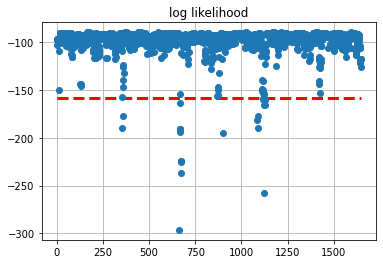

In [463]:

plt.close('all')

# cargar dataset
df = pd.read_csv("https://raw.githubusercontent.com/KevinFDI/IML_Practica_4/main/datasets/who_life_expectancy.csv")
df= df.dropna()
df = df.drop(["Country", "Year", "Status"],axis=1)
data = df.values

# fit a Gaussian Mixture Model
k = 1
modelo = GaussianMixture(n_components=k, verbose=True, covariance_type='full')
modelo.fit(data)
print('Score de todo el modelo: ', modelo.score(data))

# visualizar scores
scores = modelo.score_samples(data)
# scores= np.exp(scores) # Convertir a probabilidades

#  detectar anómalos
u_scores = np.mean(scores)
s_scores = np.std(scores)
linea_de_corte = u_scores - 4*s_scores
anomalos_ind = scores < linea_de_corte
anomalos = data[anomalos_ind]
print("Cantidad de Datos anómalos:", len(anomalos))

plt.figure()
plt.title('log likelihood')
plt.plot(scores, 'o')
plt.hlines(linea_de_corte, 0, data.shape[0],
           color='r', linestyle='--', linewidth=3)
plt.grid()
plt.show()

**Detección de anomalías con Gaussian Mixture Models**

**Carga del dataset**

In [464]:
df = pd.read_csv("https://raw.githubusercontent.com/KevinFDI/IML_Practica_4/main/datasets/who_life_expectancy.csv")

In [465]:
plt.close('all')

In [466]:
df.head(2)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0


**Renombro los nombres de las columnas**

In [467]:
df.rename(columns={
    "Life expectancy ": "Life_Expectancy",	
    "Adult Mortality": "Adult_Mortality",	
    "infant deaths": "Infant_Deaths",	
    "percentage expenditure": "Percentage_Expenditure",	
    "Hepatitis B": "Hepatitis_B",	
    "Measles ": "Measles", 
    " BMI ": "BMI", 
    "under-five deaths ": "Under_Five_Deaths",
    "Total expenditure": "Total_Expenditure",	
    " HIV/AIDS": "HIV/AIDS",
    "Diphtheria ": "Diphtheria",		
    " thinness  1-19 years": "Thinness_1-19_years",
    " thinness 5-9 years": "Thinness_5-9_years",
    "Income composition of resources": "Income_Composition_of_Resources"
    },
    inplace=True)

**Elimino los valores nulos**

In [468]:
df = df.dropna()

**Al igual que en otros trabajos (ejm. el TP 2) elimino los strings y la columna de Year**

In [469]:
df = df.drop(["Country", "Year", "Status"], axis=1)

**Normalizo**

In [470]:
NORMALIZAR = 1
if (NORMALIZAR):
    scaler_GMM = StandardScaler()
    scaler_GMM.fit(df)
    df = scaler_GMM.transform(df)

In [471]:
data = pd.DataFrame(df).values

**Fit a Gaussian Mixture Model**

In [472]:
k = 1
modelo = GaussianMixture(n_components = k, verbose = True, covariance_type = "full")
modelo.fit(data)
print('Score de todo el modelo: ', modelo.score(data))

Initialization 0
Initialization converged: True
Score de todo el modelo:  -18.21033160433209


**Graficar GMM**

In [473]:
# Quice graficar como en el modelo de Motores el GMM pero me saltaba error, probé las siguientes opciones y no encontré la solución:
# graficar_GMM(pd.DataFrame(df), modelo, probs = False, labels = False)
# graficar_GMM(pd.DataFrame(data), modelo, probs = False, labels = False)
# graficar_GMM(data, modelo, probs = False, labels = False)
# graficar_GMM(df, modelo, probs = False, labels = False)

**Visualizar scores**

In [474]:
scores = modelo.score_samples(data)

In [475]:
# scores= np.exp(scores) # Convertir a probabilidades

# **Detectar anónamlos por GMM**

In [476]:
u_scores = np.mean(scores)
s_scores = np.std(scores)
linea_de_corte = u_scores - 4*s_scores
anomalos_ind = scores < linea_de_corte
anomalos = data[anomalos_ind]
print('Datos anómalos'), print(anomalos)

Datos anómalos
[[ 5.91039029e-01 -5.68483347e-01  1.93233912e+00 -6.53421116e-02
  -3.75135057e-01  6.16570480e-01  1.28156099e+01 -5.88842974e-01
   1.61978592e+00  6.87737834e-01 -5.94219284e-01  5.95418511e-01
  -3.12388615e-01 -1.82593067e-01 -1.89227077e-01 -7.62612960e-02
  -1.95119277e-01  2.20991362e-01 -7.86858867e-02]
 [ 5.22811982e-01 -5.52518141e-01  2.47864906e+00 -4.00498771e-01
  -2.99832379e-01  1.86830924e-01  1.20993366e+01 -7.10372676e-01
   2.13560246e+00  1.53067804e-01 -5.63767132e-01  1.31868573e-01
  -3.12388615e-01 -3.32328672e-01 -2.07842936e-01  3.24855711e-02
  -1.09141139e-01  1.33787574e-02 -5.43878759e-01]
 [-1.48087308e-01  1.26003143e-01  7.65203863e+00 -3.63259142e-01
  -3.48242151e-01 -8.50523736e-03  7.67038322e+00 -1.01419693e+00
   7.09726629e+00  1.94002972e-02 -5.50716210e-01  3.91585849e-02
  -2.95806325e-01 -3.48044529e-01  1.81604680e+01  4.77384897e+00
   4.83460181e+00 -1.34135462e-01 -1.86038088e-01]
 [-1.93572005e-01  1.49950953e-01  8.007

(None, None)

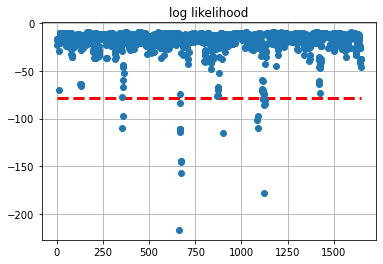

In [477]:
plt.figure()
plt.title('log likelihood')
plt.plot(scores, 'o')
plt.hlines(linea_de_corte, 0, data.shape[0],
           color='r', linestyle='--', linewidth=3)
plt.grid()
plt.show()

# **Detectar anónamlos por DBSCAN**

In [478]:
data_1 = pd.DataFrame(df).values

**PARAM**

In [479]:
EPS_1 = 0.5     # Epsilon: distancia para considerar dos datos vecinos.
MINSAM_1 = 5    # Min_samples: mínima cantidad de datos necesarios para considerarse un core sample.

**Compute DBSCAN**

In [480]:
db_1 = DBSCAN(eps=EPS_1, min_samples=MINSAM_1).fit(data_1)
labels_1 = db_1.labels_

**Number of clusters in labels, ignoring noise if present**

In [481]:
n_clusters__1 = len(set(labels_1)) - (1 if -1 in labels_1 else 0)
n_noise__1 = list(labels_1).count(-1)

print('Num estimado de clusters: %d' % n_clusters__1)
print('Num estimado de outliers: %d / %d total' % (n_noise__1, len(data_1)))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(data_1, labels_1))

Num estimado de clusters: 13
Num estimado de outliers: 1552 / 1649 total
Silhouette Coefficient: -0.391


**Visualizo la predicción**

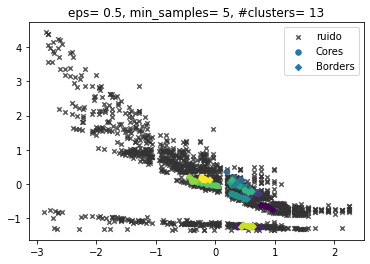

In [482]:
graficar_DBSCAN_2D(data_1, labels_1, db_1, EPS_1, MINSAM_1, n_clusters__1)

# **OBSERVACION:**

In [483]:
print("Cantidad de anómalos bajo el modelo de GMM", len(anomalos))

Cantidad de anómalos bajo el modelo de GMM 22


**En la comparacion de los datos anómalos entre el modelo de GMM y el modelo DBSCAN se puede observar que en el modelo de DBSCAN hay muchisimo mas ruido (anómalos) en comparación a los 22 del modelo de GMM. De todos modos, si se incrementa el EPS éstos disminuyen.**